# Problem description

The majority of available models, trained for object detection and recognition tasks in the field of autonomous/automated driving systems, considers only large objects such as trees on the side of the road, pedestrians, surrounding vehicles, large animals or road blockages.

Detecting small (low-level) obstacles on the road has posed a challenge, mainly due to the noise, or skew, in their pixel frequency or the small size of features that can describe these obstacles relative to the size of the frame. It is difficult for Neural Networks to approximate these type of objects, therefore many times they are randomly classified.

Recently, however, small obstacle detection has gained more popularity as  the demand for fully automated vehicles rose. Detecting unexpected small obstacles on the road could prevent the accidents caused by falling debris, construction activities or lost cargo, etc, providing a safer driving experience.

# About the Dataset

The **Lost and Found** dataset contains images combined with RGB depth information used to segment the image, determining the pixels that belong either to obstacles, road or non-road surfaces. 

The problem with this dataset is that it has a limited depth of 20m and the poor accuracy of detecting very small objects.

The **Small Obstacle Dataset**, created by the Robotics Research Center IIIT from India, collected images as well as sensor data using a highly accurate Lidar sensor, detecting objects up to a depth of 75m. The data between the 2 devices is calibrated in order to obtain a better representation of the driving conditions. The images as well as the sensor data are labeled in order to detect only small level obstacles, which means they are specialized exactly for this type of task.

It consists of 2 sets: one containing data obtained from real-life situations, while the second set contains data from a simulator in Unreal Engine.



Start by importing the necessary libraries. The images as well as the point clouds will be plotted using the plotly.matplotlib library.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import csv
import open3d as o3d
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import scipy
import fnmatch
import pandas as pd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# ------------------real data-----------------------------
TRAIN_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/train"
VAL_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/val"
TEST_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/test"

LABELS_DIR = "/labels"
IMAGE_DIR = "/image"
ODOMETRY_DIR = "/odometry"
VELODYNE_DIR = "/velodyne"

## Load data

In [4]:
def save_to_csv(output_path, headers, data):
    with open(output_path, 'w', newline='') as file:
        writer = csv.writer(file)
        # write headers in first row
        writer.writerow(headers)
        # write the data from the given list
        for row in data:
            writer.writerow(row)

### Load image data

In [5]:
def load_image_data(root_dir):
    data = []
    for root, dirs, files in os.walk(root_dir):
        if root.endswith("image"):
            files = [os.path.join(root, f).replace("\\", "/") for f in files if f.endswith('.png')]
            images = list(filter(lambda f: os.path.isfile(f.replace("/image", "/labels")), files))
            labels = [img.replace("/image", "/labels") for img in images]
            data += map(lambda t: [t[0], t[1]], zip(images, labels))

    return data

Store the path to the images and their respective labels, in a csv file.

In [6]:
train_img_csv_path = TRAIN_BASE_DIR + '/train_images.csv'
val_img_csv_path = VAL_BASE_DIR + '/val_images.csv'
test_img_csv_path = TEST_BASE_DIR + '/test_images.csv'

img_label_headers = ["image", "label"]

In [7]:
train_img_data = load_image_data(TRAIN_BASE_DIR)
print("Found %d train images along with their semantic masks" % len(train_img_data))
# save to csv file
save_to_csv(train_img_csv_path, img_label_headers, train_img_data)

Found 1932 train images along with their semantic masks


In [8]:
val_img_data = load_image_data(VAL_BASE_DIR)
print("Found %d val images along with their semantic masks" % len(val_img_data))
# save to csv file
save_to_csv(val_img_csv_path, img_label_headers, val_img_data)

Found 496 val images along with their semantic masks


In [9]:
test_img_data = load_image_data(TEST_BASE_DIR)
print("Found %d test images along with their semantic masks" % len(test_img_data))
# save to csv file
save_to_csv(test_img_csv_path, img_label_headers, test_img_data)

Found 491 test images along with their semantic masks


In [10]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

In [11]:
train_image_df = pd.read_csv(train_img_csv_path)
print("Columns: ", train_image_df.columns.values)
print("Shape: ", train_image_df.shape)

Columns:  ['image' 'label']
Shape:  (1932, 2)


In [12]:
train_image_df.head()

,image,label
0,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
1,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
2,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
3,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
4,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...


In [13]:
def load_and_preprocess_image(path):
    img_file = tf.io.read_file(path)
    img_array = tf.io.decode_png(img_file, channels=3)
    img_resized = tf.image.resize(img_array, [IMG_HEIGHT, IMG_WIDTH])
    return img_resized


def load_and_preprocess_image_and_label(row):
    img_data = load_and_preprocess_image(row[0])
    label_data = load_and_preprocess_image(row[1])
    return img_data, label_data

In [14]:
train_tensor = tf.data.Dataset.from_tensor_slices(train_image_df[['image', 'label']].values)
train_tensor = train_tensor.map(load_and_preprocess_image_and_label, tf.data.experimental.AUTOTUNE)
print(train_tensor.element_spec)

(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None))


In [15]:
it = train_tensor.shuffle(len(train_image_df.values)).batch(32).as_numpy_iterator()
it.next()

(array([[[[ 10.527778 ,  14.527778 ,  13.527778 ],
          [ 10.       ,  14.       ,  13.       ],
          [  9.5      ,  13.5      ,  12.5      ],
          ...,
          [ 11.55481  ,  24.138245 ,  23.2771   ],
          [158.8324   , 158.99902  , 168.3324   ],
          [ 28.138855 ,  30.111084 ,  37.638855 ]],
 
         [[ 12.527778 ,  16.527779 ,  15.527778 ],
          [ 13.416666 ,  17.416666 ,  16.416666 ],
          [  7.5      ,  11.5      ,  10.5      ],
          ...,
          [ 26.44458  ,  32.083435 ,  33.94458  ],
          [ 50.916443 ,  55.916443 ,  59.916443 ],
          [ 24.333374 ,  29.861145 ,  33.333374 ]],
 
         [[  7.9444447,  11.944445 ,  10.944445 ],
          [  7.5      ,  11.5      ,  10.5      ],
          [  6.1388893,   9.       ,   9.       ],
          ...,
          [ 25.305725 ,  31.305725 ,  34.805725 ],
          [ 19.749939 ,  25.749939 ,  27.833252 ],
          [ 20.527771 ,  26.527771 ,  28.527771 ]],
 
         ...,
 
         [[ 

### Load lidar data

In [16]:
def load_lidar_data(root_dir):
    lidar_data = []
    calibration_data = []
    i = 0
    for root, dirs, files in os.walk(root_dir):
        if root.endswith("velodyne"):
            files = [os.path.join(root, f).replace("\\", "/") for f in files if f.endswith('.npy')]
            lidar_data += list(map(lambda f: [f, i], files))
            i += 1
        calibration_data += [os.path.join(root, f).replace("\\", "/") for f in files if f.endswith('.txt')]

    data = list(map(lambda e: [e[0], calibration_data[e[1]]], lidar_data))
    return data

Store the path to the lidar point cloud files in a csv file.

In [17]:
train_lidar_csv_path = TRAIN_BASE_DIR + '/train_lidar.csv'
val_lidar_csv_path = VAL_BASE_DIR + '/val_lidar.csv'
test_lidar_csv_path = TEST_BASE_DIR + '/test_lidar.csv'

lidar_headers = ["lidar", "calibration"]

In [18]:
train_lidar_data = load_lidar_data(TRAIN_BASE_DIR)
print("Found %d train lidar npy files" % len(train_lidar_data))
# save to csv file
save_to_csv(train_lidar_csv_path, lidar_headers, train_lidar_data)

Found 5696 train lidar npy files


In [19]:
val_lidar_data = load_lidar_data(VAL_BASE_DIR)
print("Found %d validation lidar npy files" % len(val_lidar_data))
# save to csv file
save_to_csv(val_lidar_csv_path, lidar_headers, val_lidar_data)

Found 1688 validation lidar npy files


In [20]:
test_lidar_data = load_lidar_data(TEST_BASE_DIR)
print("Found %d test lidar npy files" % len(test_lidar_data))
# save to csv file
save_to_csv(test_lidar_csv_path, lidar_headers, test_lidar_data)

Found 1130 test lidar npy files


In [21]:
train_lidar_df = pd.read_csv(train_lidar_csv_path)
print("Columns: ", train_lidar_df.columns.values)
print("Shape: ", train_lidar_df.shape)

Columns:  ['lidar' 'calibration']
Shape:  (5696, 2)


In [22]:
train_lidar_df.head()

,lidar,calibration
0,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
1,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
2,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
3,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
4,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...


In [23]:
def read_calibration_data(calibration_file):
    with open(calibration_file, 'r') as f:
        reader = csv.reader(f)
        coord = []
        for line in reader:
            if len(line) > 0 and len(line[0]) > 0 and line[0][0] != '#':
                # add each line which contains valid numbers (not comments '#' or empty strings ' '
                # remove the last token, which is the empty space at the end of each line
                coord.append(line[0].split(' ')[:-1])
        # convert the string values to float
        coord = np.asarray(coord, 'float64')
        # read 7x4 values, from which:
        ## first 3x4 values represent the intrinsic camera transformation matrix
        ## the next 4x4 values represent the extrinsic lidar-camera transformation matrix

        coord = np.reshape(coord, (7, 4))
        int_mat = coord[:3]
        ext_mat = coord[3:]

        return int_mat, ext_mat

def apply_camera_projection(points, camera_int, camera_ext):
    project = lambda p, camera_int, camera_ext: camera_int @ camera_ext.dot(p[:4])
    normalize = lambda p: (p / p[2])[:-1]
    points[:,3] = 1
    return [normalize(project(p, camera_int, camera_ext)) for p in points]

def project_points_to_image(points, img_height, img_width):
    # create a white canvas on which the points wil be projected
    img_mat = np.full((img_height, img_width, 3), [255,255,255])
    for p in points:
        i = int(p[0]) % IMG_WIDTH
        j = int(p[1]) % IMG_HEIGHT
        img_mat[i][j] = [0,0,0]
    return img_mat

def load_and_preprocess_lidar(row):
    lidar_path = row[0]
    calibration_path = row[1]
    pcd = np.load(lidar_path)
    camera_int, camera_ext = read_calibration_data(calibration_path)
    camera_int[0][2] = IMG_WIDTH/2
    camera_int[1][2] = IMG_HEIGHT/2
    camera_int[0][0] = 1/IMG_WIDTH
    camera_int[1][1] = 1/IMG_HEIGHT
    plane_projection = apply_camera_projection(pcd, camera_int, camera_ext)
    img = project_points_to_image(plane_projection, 180, 180)
    return img

In [40]:
train_lidar_proj_df = train_lidar_df[:BATCH_SIZE].apply(load_and_preprocess_lidar, axis=1)

In [41]:
train_lidar_tensor = tf.data.Dataset.from_tensor_slices(train_lidar_proj_df.tolist())
print(train_lidar_tensor.element_spec)

TensorSpec(shape=(180, 180, 3), dtype=tf.int32, name=None)


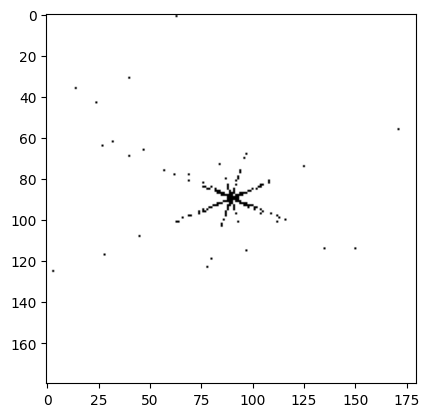

In [44]:
it = train_lidar_tensor.shuffle(len(train_lidar_proj_df.values)).batch(32).as_numpy_iterator()
sample_img = it.next()[10]
plt.imshow(sample_img)

In [29]:
train_lidar_tensor = tf.data.Dataset.from_tensor_slices(train_lidar_proj_df)
train_lidar_tensor = train_lidar_tensor.map(load_and_preprocess_lidar, tf.data.experimental.AUTOTUNE)
print(train_lidar_tensor.element_spec)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

## Visualize the data

1. Visualize image data

In [ ]:
def view_image_input(image_dir, labels_dir, input_file_name):
    img_path = image_dir + "/" + input_file_name
    img = mpimg.imread(img_path)

    segm_path = labels_dir + "/" + input_file_name
    segm = mpimg.imread(segm_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

    ax1.set_title("Input image")
    ax1.imshow(img)

    ax2.set_title("Segmentation mask")
    ax2.imshow(segm)

    plt.show(block=True)

In [ ]:
print("Real image sample:")
view_image_input(TRAIN_BASE_DIR + "/file_1" + IMAGE_DIR, TRAIN_BASE_DIR + "/file_1" + LABELS_DIR, "0000000080.png")

2. Visualize Lidar data

In [ ]:
def view_lidar_plot(base_dir, input_file_name, calibration):
    lidar_path = os.path.join(base_dir, input_file_name)
    pcd = np.load(lidar_path)
    intensities = pcd[:, 3]

    _ = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.set_title("Lidar point cloud")
    x = pcd[:, 0]
    y = pcd[:, 1]
    z = pcd[:, 2]
    ax.scatter3D(x, y, z, c=intensities, linewidth=0.3)
    plt.show()

In [ ]:
def view_lidar_3d(base_dir, input_file_name):
    lidar_path = os.path.join(base_dir, input_file_name).replace('\\', '/')
    pcd = np.load(lidar_path)
    pcd = pcd[:, :3]
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(pcd)
    o3d.visualization.draw_geometries([point_cloud])

In [ ]:
# real road scenario
view_lidar_3d(TRAIN_BASE_DIR + "/file_1" + VELODYNE_DIR, "0000000080.npy")

## Lost and Found dataset

In [ ]:
lost_found_dataset, info = tfds.load('lost_and_found',
                                     with_info=True)

The lost and found dataset contains 2104 annotated frames gathered from 112 video seqeunces: http://wwwlehre.dhbw-stuttgart.de/~sgehrig/lostAndFoundDataset/index.html

In [ ]:
info.features

In [ ]:
lost_found_dataset['train']

View a few sample images from the dataset:

In [ ]:
_ = tfds.visualization.show_examples(lost_found_dataset['train'], info, image_key="image_left")

In [ ]:
_ = tfds.visualization.show_examples(lost_found_dataset['train'], info, image_key="segmentation_label")

In [ ]:
lost_found_dataset